In [ ]:
# Importació de llibreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
import plotly.io as pio

# Preprocessament
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest

# Models
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
import pandas as pd
file = "Amazon_Stock_Price_final.csv"
data = pd.read_csv(file)

In [ ]:
np.random.seed(42)

In [ ]:
# Normalització
def normalize_data(data):
    features = ["Open","High","Low","Close","Volume","EMA_7","EMA_40",
                "MACD","Signal_Line","MACD_Hist","RSI","ATR"]
    
    # Inicialitza els escaladors
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Escala la resta de característiques
    data[features] = feature_scaler.fit_transform(data[features])
    
    return data, feature_scaler

data, feature_scaler = normalize_data(data)
print("Dades després de la normalització:")
display(data)

Dades després de la normalització:


,Date,Open,High,Low,Close,Volume,EMA_7,EMA_40,MACD,Signal_Line,MACD_Hist,RSI,ATR
0,2020-01-02,0.074364,0.071806,0.075991,0.081628,0.221739,0.068970,0.029943,0.598687,0.595578,0.494401,0.086173,0.000000
1,2020-01-03,0.070987,0.068096,0.076054,0.074451,0.203550,0.067093,0.029534,0.594269,0.594557,0.483465,0.086173,0.000000
2,2020-01-06,0.069585,0.073566,0.074651,0.083125,0.223729,0.067954,0.029639,0.596198,0.594185,0.490427,0.086173,0.000000
3,2020-01-07,0.083732,0.076773,0.084859,0.084373,0.228353,0.068926,0.029810,0.598506,0.594422,0.496936,0.086173,0.000000
4,2020-01-08,0.081692,0.075893,0.083073,0.079755,0.186374,0.068447,0.029710,0.597474,0.594373,0.493873,0.086173,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2025-03-27,0.757089,0.756476,0.752760,0.746006,0.041540,0.758196,0.859697,0.386996,0.257809,0.743252,0.424594,0.817081
1316,2025-03-28,0.741350,0.727993,0.705545,0.692087,0.126679,0.745567,0.854034,0.373220,0.273220,0.659379,0.293336,0.858729
1317,2025-03-31,0.676161,0.678131,0.657819,0.676735,0.163798,0.732080,0.847772,0.355546,0.281463,0.582630,0.261893,0.883161
1318,2025-04-01,0.674058,0.694479,0.675684,0.688655,0.088614,0.725083,0.842496,0.351808,0.287192,0.555728,0.305496,0.886328


In [ ]:
# Crear seqüències per a l'LSTM
def create_sequences(data, seq_length, target_col='Close'):
    """
    Crea seqüències d’entrada i objectius corresponents per a la predicció de sèries temporals
    """
    X, y = [], []
    features = ["Open","High","Low","Volume","EMA_7","EMA_40",
                "MACD","Signal_Line","MACD_Hist","RSI","ATR"]
    
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length][target_col])
    
    return np.array(X), np.array(y)

# Augmentació de dades amb jittering
def jitter(X, noise_factor=0.01):
    """
    Afegeix soroll aleatori suau a les seqüències per augmentar les dades
    """
    noise = np.random.normal(0, noise_factor, X.shape)
    return X + noise

# Paràmetres
SEQ_LENGTH = 10  # Nombre de dies que es consideren enrere
TEST_SIZE = 0.2  # Percentatge de dades destinat a test

# Crear seqüències
X, y = create_sequences(data, SEQ_LENGTH)

# Augmentació de dades
X_augmented = jitter(X)
X = np.concatenate([X, X_augmented])
y = np.concatenate([y, y])

print(f"Forma final del conjunt de dades: X = {X.shape}, y = {y.shape}")


Forma final del conjunt de dades: X = (2620, 10, 11), y = (2620,)


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1320 non-null   object 
 1   Open         1320 non-null   float64
 2   High         1320 non-null   float64
 3   Low          1320 non-null   float64
 4   Close        1320 non-null   float64
 5   Volume       1320 non-null   float64
 6   EMA_7        1320 non-null   float64
 7   EMA_40       1320 non-null   float64
 8   MACD         1320 non-null   float64
 9   Signal_Line  1320 non-null   float64
 10  MACD_Hist    1320 non-null   float64
 11  RSI          1320 non-null   float64
 12  ATR          1320 non-null   float64
dtypes: float64(12), object(1)
memory usage: 134.2+ KB
None


In [ ]:
# Separació entrenament-test amb validació creuada per sèries temporals
def train_test_split_time_series(X, y, test_size=0.2):
    """
    Separació personalitzada per sèries temporals que manté l'ordre temporal
    """
    split_idx = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_time_series(X, y, TEST_SIZE)

print(f"Conjunt d'entrenament: {X_train.shape}, {y_train.shape}")
print(f"Conjunt de test: {X_test.shape}, {y_test.shape}")

Conjunt d'entrenament: (2096, 10, 11), (2096,)
Conjunt de test: (524, 10, 11), (524,)


In [ ]:
# LSTM Model
def build_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.2, learning_rate=0.001):
    """
    Build and compile LSTM model
    """
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(lstm_units//2),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Inicialitzar LSTM model
lstm_model = build_lstm_model((SEQ_LENGTH, X_train.shape[2]))

lstm_model.summary()

c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,345 (130.25 KB)

 Trainable params: 33,153 (129.50 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
#Entrenament model LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5924 - mae: 0.5394 - val_loss: 0.1114 - val_mae: 0.2816
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1401 - mae: 0.2897 - val_loss: 0.0945 - val_mae: 0.2607
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0834 - mae: 0.2302 - val_loss: 0.0886 - val_mae: 0.2456
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0575 - mae: 0.1869 - val_loss: 0.0761 - val_mae: 0.2286
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0429 - mae: 0.1641 - val_loss: 0.0475 - val_mae: 0.1823
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0361 - mae: 0.1483 - val_loss: 0.0299 - val_mae: 0.1464
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0309 - mae: 0.1362 - val_loss: 0.0259 - val_mae: 0.1357
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0226 - mae: 0.1189 - val_loss: 0.0096 - val_mae: 0.0826
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.02

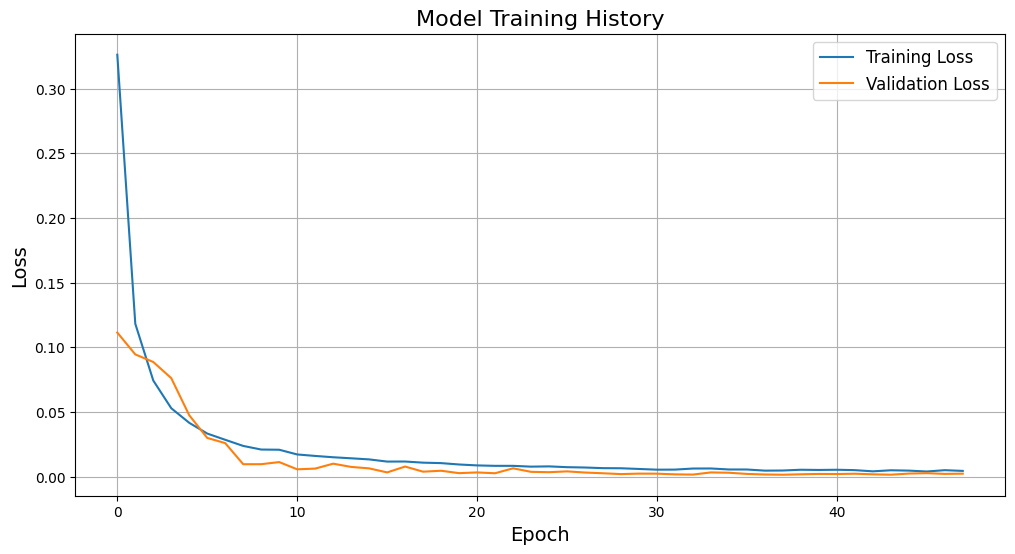

In [ ]:
# Representació gràfica de l'historial d'entrenament
def plot_training_history(history):
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Training History', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_training_history(history)

In [ ]:
y_pred_lstm = lstm_model.predict(X_train).flatten()
residuals = y_train - y_pred_lstm

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Entrenar el model XGBoost
xgb_X_train = X_train.reshape(X_train.shape[0], -1)
xgb_residual_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_residual_model.fit(xgb_X_train, residuals)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

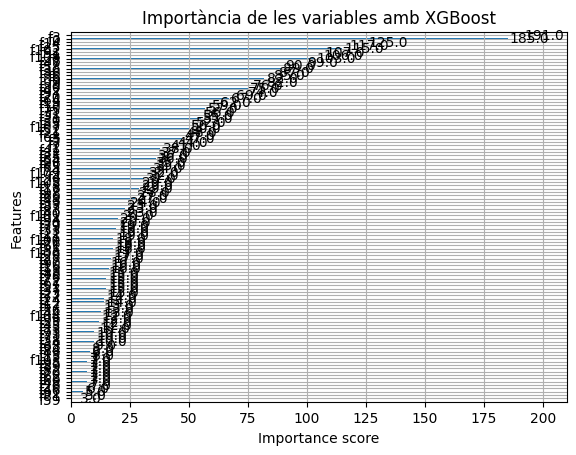

In [ ]:
# Importància de les variables
xgb.plot_importance(xgb_residual_model)
plt.title('Importància de les variables amb XGBoost')
plt.show()

In [ ]:
# Predicció de LSTM sobre les dades de test
y_lstm_test_pred = lstm_model.predict(X_test).flatten()

# Preparar X per a XGBoost
xgb_X_test = X_test.reshape(X_test.shape[0], -1)

# Predir residus
residual_preds = xgb_residual_model.predict(xgb_X_test)

# Combinar prediccions
final_preds = y_lstm_test_pred + residual_preds


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# Funció avaluar model usant mètriques
def evaluate_models(y_true, y_lstm_test_pred, final_preds):

    results = []
    
    def calculate_metrics(y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        return {
            "Model": model_name,
            "MSE": round(mse, 6),
            "MAE": round(mae, 6),
            "R² Score": round(r2, 4)
        }
    
    results.append(calculate_metrics(y_true, y_lstm_test_pred, "LSTM"))
    results.append(calculate_metrics(y_true, final_preds, "Hybrid"))
    
    return pd.DataFrame(results)

# Evaluar model
results_df = evaluate_models(y_test, y_lstm_test_pred, final_preds)
print("Model Performance Comparison:")
display(results_df)

Model Performance Comparison:


,Model,MSE,MAE,R² Score
0,LSTM,0.001325,0.027157,0.9755
1,Hybrid,0.000165,0.009541,0.9970


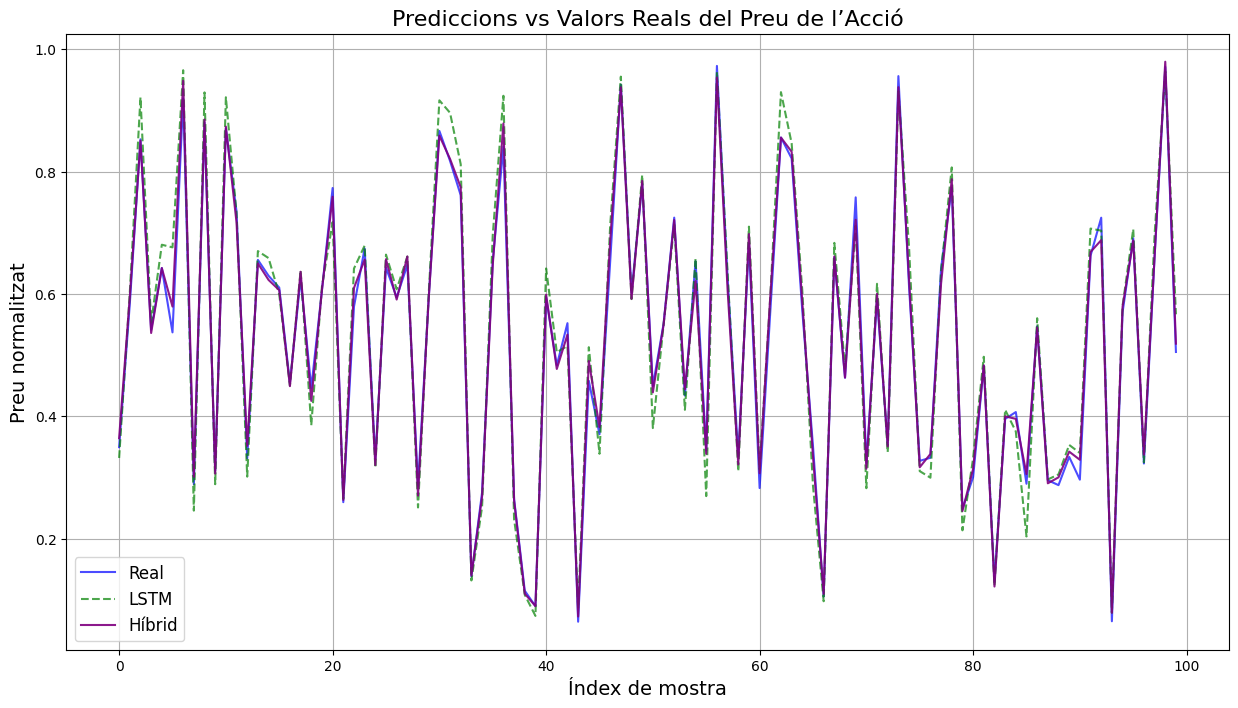

In [ ]:
# Visualitzar les prediccions vs valors reals
def plot_predictions(y_true, y_lstm_test_pred, final_preds, n_samples=100):
    
    plt.figure(figsize=(15, 8))
    
    # Selecciona un subconjunt per visualitzar més clarament
    idx = np.random.choice(len(y_true), size=min(n_samples, len(y_true)), replace=False)
    
    plt.plot(y_true[idx], label='Real', color='blue', alpha=0.7)
    plt.plot(y_lstm_test_pred[idx], label='LSTM', color='green', linestyle='--', alpha=0.7)
    plt.plot(final_preds[idx], label='Híbrid', color='purple', linestyle='-', alpha=0.9)
    
    plt.title('Prediccions vs Valors Reals del Preu de l’Acció', fontsize=16)
    plt.xlabel('Índex de mostra', fontsize=14)
    plt.ylabel('Preu normalitzat', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_predictions(y_test, y_lstm_test_pred, final_preds)


In [ ]:
# Transformar les prediccions a l’escala original
def inverse_transform_predictions(preds, scaler):

    # Reestructurar per fer la transformació inversa
    preds_2d = preds.reshape(-1, 1)
    dummy = np.zeros((len(preds_2d), len(feature_scaler.feature_names_in_)))
    
    # Posar les prediccions a la columna corresponent a 'Close'
    close_idx = list(feature_scaler.feature_names_in_).index('Close')
    dummy[:, close_idx] = preds_2d.flatten()
    
    # Fer la transformació inversa
    original_scale = feature_scaler.inverse_transform(dummy)[:, close_idx]
    
    return original_scale

close_scaler=data['Close']
# Obtenir els preus reals a escala original
actual_prices = inverse_transform_predictions(y_test, close_scaler)
hybrid_prices = inverse_transform_predictions(final_preds, close_scaler)

# Representar gràficament les prediccions finals vs preus reals
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Preu Real', color='blue')
plt.plot(hybrid_prices, label='Preu Previst', color='red', linestyle='--')
plt.title('Preus Reals vs Predits (Escala Original)', fontsize=16)
plt.xlabel('Instants de Temps', fontsize=14)
plt.ylabel('Preu ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

NameError: name 'close_scaler' is not defined

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Crear figura amb Plotly
fig = go.Figure()

# Afegir línia per als valors reals
fig.add_trace(go.Scatter(
    x=data['Date'].iloc[-len(actual_prices):], 
    y=actual_prices, 
    mode='lines', 
    name='Preu real (Close)', 
    line=dict(color='blue')
))

# Afegir línia per als valors predits del model híbrid
fig.add_trace(go.Scatter(
    x=data['Date'].iloc[-len(hybrid_prices):], 
    y=hybrid_prices, 
    mode='lines', 
    name='Predicció híbrida', 
    line=dict(color='red', dash='dash')
))

# Configuració del gràfic
fig.update_layout(
    title='Predicció del Preu de les Accions (Amazon)',
    xaxis_title='Data',
    yaxis_title='Preu de l\'acció (USD)',
    template='plotly_dark',
    xaxis_rangeslider_visible=True
)

pio.renderers.default = 'browser'
fig.show()


In [ ]:
future_preds_scaled = []
sequence = X_test[-1].copy()  
future_dates = []
last_date = data.iloc[-1]["Date"] 

for i in range(10):
    # Predicció LSTM (en escala normalitzada)
    pred_lstm = lstm_model.predict(sequence.reshape(1, sequence.shape[0], sequence.shape[1])).flatten()[0]

    # Predicció del residu amb XGBoost (també escala normalitzada)
    xgb_input = sequence.reshape(1, -1)
    pred_residual = xgb_residual_model.predict(xgb_input)[0]

    # Combinació final (en escala normalitzada)
    pred_final_scaled = pred_lstm + pred_residual
    future_preds_scaled.append(pred_final_scaled)

    # Actualitza la seqüència
    new_step = sequence[-1].copy()
    new_step[0] = pred_final_scaled  
    sequence = np.vstack([sequence[1:], new_step])
    
    # Guardar la predicció i la data
    next_day_date = pd.to_datetime(last_date) + pd.Timedelta(days=i + 1)
    future_dates.append(next_day_date.strftime('%Y-%m-%d'))

# Desescalat final
future_preds_original = inverse_transform_predictions(np.array(future_preds_scaled), feature_scaler)

# Resultat
print("Prediccions en escala original:")
for i, val in enumerate(future_preds_original, 1):
    print(f"Dia {i}: {val:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediccions en escala original:
Dia 1: 195.82
Dia 2: 192.35
Dia 3: 192.80
Dia 4: 190.19
Dia 5: 188.98
Dia 6: 188.36
Dia 7: 181.71
Dia 8: 185.38
Dia 9: 185.80
Dia 10: 186.18


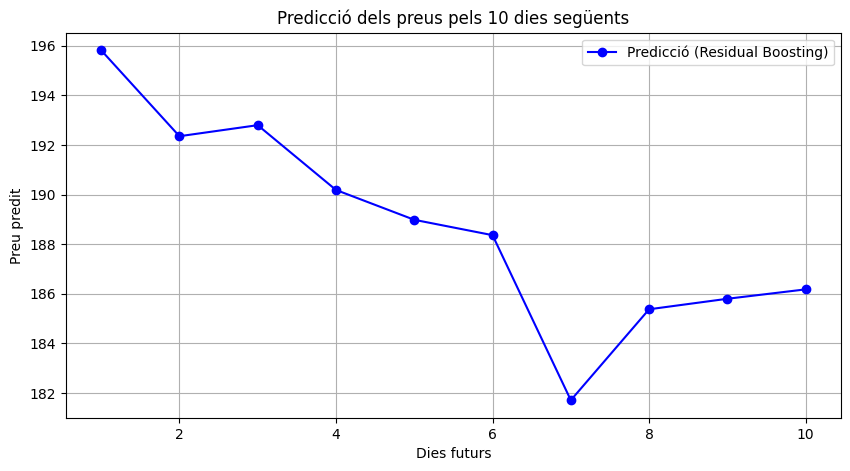

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), future_preds_original, marker='o', linestyle='-', color='blue', label='Predicció (Residual Boosting)')
plt.title('Predicció dels preus pels 10 dies següents')
plt.xlabel('Dies futurs')
plt.ylabel('Preu predit')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
## --- GRÀFIC DE PREDICCIÓ FUTURA ---
future_dates_dt = pd.to_datetime(future_dates)

fig_future = go.Figure()

# Històric
fig_future.add_trace(go.Scatter(
    x=data['Date'].iloc[-len(actual_prices):], 
    y=actual_prices, 
    mode='lines', 
    name='Preu real (Close)', 
    line=dict(color='blue')
))
# Prediccions futures
fig_future.add_trace(go.Scatter(
    x=future_dates_dt, 
    y=np.array(future_preds_original), 
    mode='lines+markers',
    name='Predicció futura', 
    line=dict(color='orange', dash='dash'),
    text=[f"{p:.2f}" for p in future_preds_original],
    textposition="top center"
))

fig_future.update_layout(
    title='Predicció dels propers 10 dies (Amazon)',
    xaxis_title='Data',
    yaxis_title='Preu Acció (USD)',
    template='plotly_dark',
    xaxis_rangeslider_visible=True
)

fig_future.show()
